In [1]:
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
from meld_classifier.define_features import Feature
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH,MELD_DATA_PATH


Setting MELD_DATA_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/output/preprocessed_surf_data
Setting EXPERIMENT_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/models
Setting FS_SUBJECTS_PATH to /home/kw350/rds/rds-kw350-meld/meld_data/Data/output/fs_outputs


In [33]:
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset="MELD_dataset_V6.csv",
             data_dir=MELD_DATA_PATH)

In [34]:
# get all patients and controls
patient_ids = cohort.get_subject_ids(group='patient')
control_ids = cohort.get_subject_ids(group='control')
print(len(patient_ids), 'patients', len(control_ids), 'controls')

# get all features
for f in cohort.full_feature_list:
    print(f)

538 patients 373 controls
.combat.on_lh.curv.sm5.mgh
.combat.on_lh.gm_FLAIR_0.25.sm10.mgh
.combat.on_lh.gm_FLAIR_0.5.sm10.mgh
.combat.on_lh.gm_FLAIR_0.75.sm10.mgh
.combat.on_lh.gm_FLAIR_0.sm10.mgh
.combat.on_lh.pial.K_filtered.sm20.mgh
.combat.on_lh.sulc.sm5.mgh
.combat.on_lh.thickness.sm10.mgh
.combat.on_lh.w-g.pct.sm10.mgh
.combat.on_lh.wm_FLAIR_0.5.sm10.mgh
.combat.on_lh.wm_FLAIR_1.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh
.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh
.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh
.inter_z.asym.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh
.

In [182]:
def get_control_features(subject_ids, feature, cohort):
    """
    preload features from controls for a list of controls
    """
    control_features = {'lh':[], 'rh': []}
    for hemi in ['lh', 'rh']:
        for sid in subject_ids:
            subj = MeldSubject(sid, cohort)
            features = subj.load_feature_values(feature, hemi=hemi)
            control_features[hemi].append(features)
        control_features[hemi] = np.stack(control_features[hemi], axis=1)
    return control_features

def get_tstat_for_subject(subject_id, feature, control_features, cohort,
                         ):
    """
    calc tstst for one subject id and preloaded control features
    """
    subj = MeldSubject(subject_id, cohort)
    hemi = subj.get_lesion_hemisphere()
    features, lesion = subj.load_feature_lesion_data([feature], hemi=hemi)
    
    patient_features = features[lesion>0].flatten()
    np.random.shuffle(lesion)
    cur_control_features = control_features[hemi][lesion>0] #.flatten()
    
    # calculate tstat
    #?average features
    mc = np.mean(cur_control_features,axis=1)
    #tstat, p = ttest_ind(patient_features, cur_control_features.flatten(), equal_var=False)
    tstat, p = ttest_ind(patient_features, mc, equal_var=False)
    #mu=np.mean(patient_features)
    #mc = np.mean(cur_control_features,axis=0)
    #z = (mu-np.mean(mc))/np.std(mc)
    #return z
    #snr = (np.mean(patient_features)-np.mean(cur_control_features))/np.std(np.hstack([cur_control_features,
                                                                             #         patient_features]))
    #return snr
    return tstat

def get_tstat(patient_ids, control_ids, feature, cohort):
    """
    return list of tstats for each patient comparing to controls
    """
    control_features = get_control_features(control_ids, feature, cohort)
    stats = []
    for pid in patient_ids:
        stats.append(get_tstat_for_subject(pid, feature, control_features, cohort))
    return stats

def get_tstat_for_features(patient_ids, control_ids, features, cohort):
    """
    calculate tstats for all patients + matching controls for all features in features dict
    """
    stats = []
    for ftype, fdict in features.items():
        cur_stats = {}
        for fname, feature in fdict.items():
            cur_stats[fname] = get_tstat(patient_ids, control_ids, feature, cohort)
        cur_stats = pd.DataFrame(cur_stats)
        cur_stats['processing'] = ftype
        stats.append(cur_stats)
    return pd.concat(stats)

In [145]:
#cohort.full_feature_list

## compare combat vs asym for noFLAIR features

In [163]:
# set up data for comparing combat vs asym features (no FLAIR features)
base_features = [
    '.on_lh.curv.mgh',
    '.on_lh.pial.K_filtered.mgh',
    '.on_lh.sulc.mgh',
   '.on_lh.thickness.mgh',
    '.on_lh.w-g.pct.mgh',
    ]
smooth = [5, 20, 5, 10, 10]

# build feature names for comparing combat vs asym
features = {
    'combat': {f:Feature(f, sm).get_combat_feature() for f,sm in zip(base_features, smooth)},
    'asym': {f:Feature(f, sm).get_asym_feature() for f,sm in zip(base_features, smooth)},
    'inter': {f:Feature(f, sm).get_norm_feature() for f,sm in zip(base_features, smooth)}
    
}
print(features)

# choose random controls to compare against
cur_control_ids = np.random.choice(control_ids, size=50, replace=False)

# Q: for FLAIR, choose only patients + controls that have flair
# Q: match scanner strength for patients + controls?

{'combat': {'.on_lh.curv.mgh': '.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.combat.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.mgh': '.combat.on_lh.w-g.pct.sm10.mgh'}, 'asym': {'.on_lh.curv.mgh': '.inter_z.asym.intra_z.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.inter_z.asym.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.inter_z.asym.intra_z.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.inter_z.asym.intra_z.combat.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.mgh': '.inter_z.asym.intra_z.combat.on_lh.w-g.pct.sm10.mgh'}, 'inter': {'.on_lh.curv.mgh': '.inter_z.intra_z.combat.on_lh.curv.sm5.mgh', '.on_lh.pial.K_filtered.mgh': '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.mgh': '.inter_z.intra_z.combat.on_lh.sulc.sm5.mgh', '.on_lh.thickness.mgh': '.inter_z.intra_z.combat.on_lh.thickness.sm10.mg

In [183]:
# get tstats for all features in features dict
stats = get_tstat_for_features(patient_ids[:100], cur_control_ids, features, cohort)

<AxesSubplot:xlabel='tstat', ylabel='feature'>

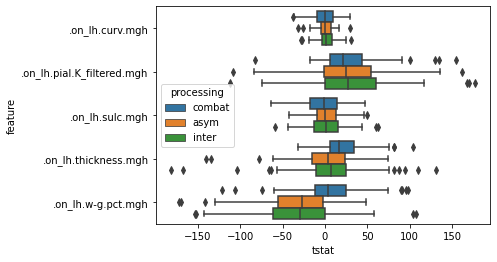

In [184]:
# bring stats in right format for plotting
df = pd.melt(stats, id_vars='processing', var_name='feature', value_name='tstat') # value_vars=keys, value_name='key')
sns.boxplot(data=df, y='feature', x='tstat', hue='processing')

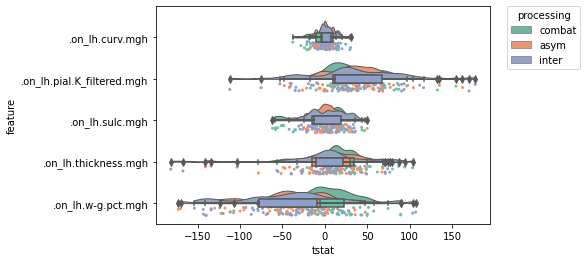

In [175]:
import ptitprince as pt

ax = pt.RainCloud(y = 'tstat', x = 'feature', hue='processing',
                  data = df, 
                  width_viol = .8,
                  width_box = .2,
                   orient = 'h',
                  move = .2,
                  offset=0)